<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [**Python Graph Gallery**](https://python-graph-gallery.com/)
- [**Wikipedia page**](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [**A short (3-4 pages) academic paper**](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

In [489]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import re

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters 
# pandas will display in a column
pd.options.display.max_colwidth = 400

# distplots from Seaborn are still awesome
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

---

## Load data

In [3]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...

# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [15]:
df['status_length'] = df['STATUS'].apply(len)

**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [25]:
# function for word counts with space 
def count_words(status):
    return len(status.split())

df['status_word_count'] = df['STATUS'].apply(count_words)

### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [45]:
df.shape

(9916, 15)

In [63]:
# longest
print(df.sort_values(by = 'status_word_count', ascending =False)['STATUS'].head(1))
longest = df['status_word_count'].max()
print(f' Length of the longest status post is {longest}')

496    Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it.  Dmv:  Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...
Name: STATUS, dtype: object
 Length of the longest status post is 89


In [57]:
# shortest
print(df.sort_values(by = 'status_word_count', ascending =False)['STATUS'].tail(1))
shortest = df['status_word_count'].min()
print(f' Length of the shortest status post is {shortest}')

5669    Tokyo.
Name: STATUS, dtype: object
 Length of the shortest status post is 1


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

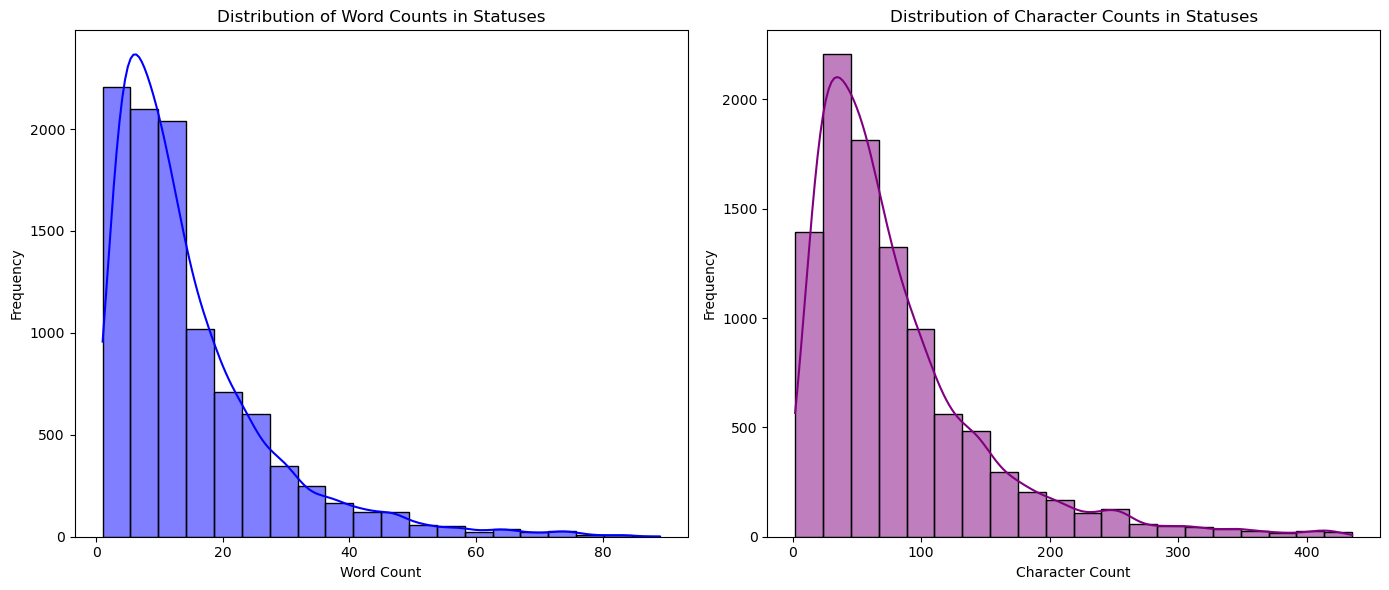

In [94]:
# Plotting the distributions
plt.figure(figsize=(14, 6))

# for word counts
plt.subplot(1, 2, 1)  # want side by side show --> (nrows, ncols, index)
sns.histplot(df['status_word_count'], bins=20, kde=True, color='blue')
plt.title('Distribution of Word Counts in Statuses')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# for character counts
plt.subplot(1, 2, 2)
sns.histplot(df['status_length'], bins=20, kde=True, color='purple')
plt.title('Distribution of Character Counts in Statuses')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# It has the heavily skew to the right (positive skewed)

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

Extra info

- Openness: A person with a high level of openness may be curious about new experiences and have imaginative thinking. A person with a low level of openness may be inflexible and closed-minded.
  
- Conscientiousness: A person with a high level of conscientiousness may be motivated and perfectionistic. A person with a low level of conscientiousness may be irresponsible, distractible, or thoughtless.
  
- Extraversion: A person with a high level of extraversion may be social, outgoing, and active. A person with a low level of extraversion may be withdrawn or cold to other
  
- Agreeableness: A person with a high level of agreeableness may want to get along with others and be selfless in their attempts. A person with a low level of agreeableness may be deceitful, manipulative, uncaring, or suspicious.
  
- Neuroticism: A person with a high level of neuroticism may be insecure, overly emotional, and perhaps depressive and helpless. A person with a low level of neuroticism may be fearless and shameless.

**people can exhibit varying degrees of each trait** <--- means that they can have many traits in on person

In [182]:
df.shape

(9916, 15)

In [86]:
df.columns  # thsu question focusing on 's' the real score

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

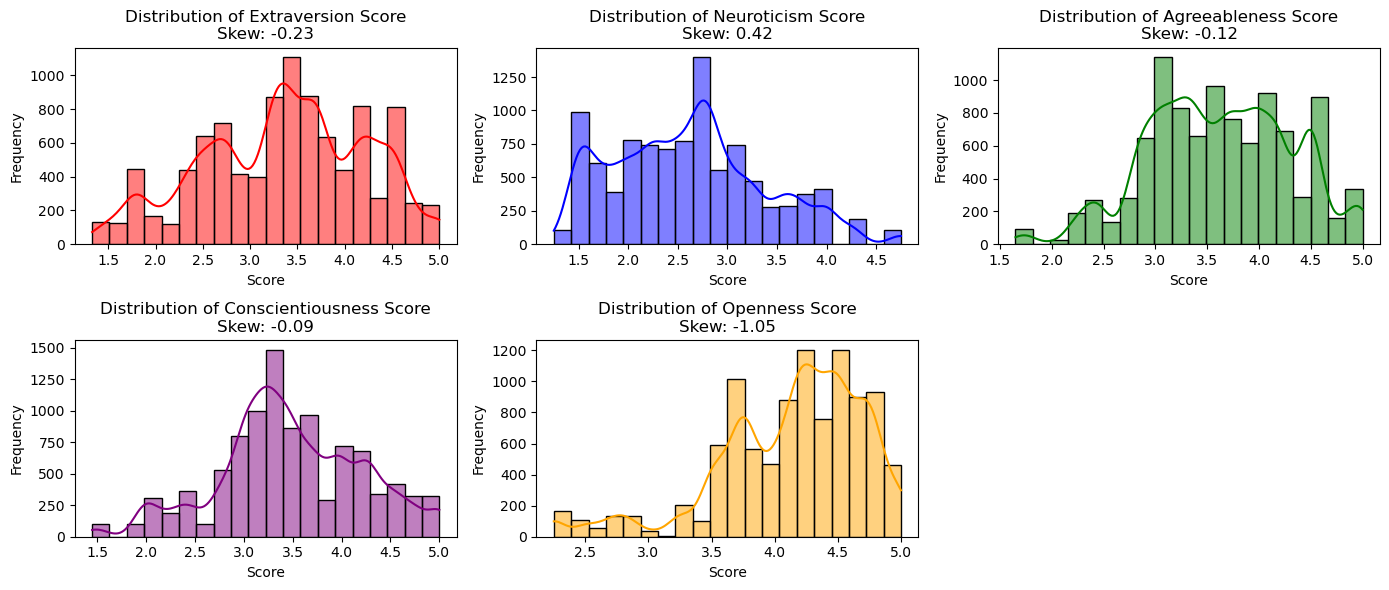

In [196]:
# Calculate skewness for each personality score
skew_ext = skew(df['sEXT'])
skew_neu = skew(df['sNEU'])
skew_agr = skew(df['sAGR'])
skew_con = skew(df['sCON'])
skew_opn = skew(df['sOPN'])

# Plotting the distributions
plt.figure(figsize=(14, 6))

# for sEXT (Extraversion)
plt.subplot(2, 3, 1)  # -- > (nrows, ncols, index)
sns.histplot(df['sEXT'], bins=20, kde=True, color='red')
plt.title(f'Distribution of Extraversion Score\nSkew: {skew_ext:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sNEU (Neuroticism)
plt.subplot(2, 3, 2)
sns.histplot(df['sNEU'], bins=20, kde=True, color='blue')
plt.title(f'Distribution of Neuroticism Score\nSkew: {skew_neu:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sAGR (Agreeableness)
plt.subplot(2, 3, 3)
sns.histplot(df['sAGR'], bins=20, kde=True, color='green')
plt.title(f'Distribution of Agreeableness Score\nSkew: {skew_agr:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sCON (Conscientiousness)
plt.subplot(2, 3, 4)
sns.histplot(df['sCON'], bins=20, kde=True, color='purple')
plt.title(f'Distribution of Conscientiousness Score\nSkew: {skew_con:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sOPN (Openness)
plt.subplot(2, 3, 5)
sns.histplot(df['sOPN'], bins=20, kde=True, color='orange')
plt.title(f'Distribution of Openness Score\nSkew: {skew_opn:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [150]:
print(f'Number of user: {df['#AUTHID'].nunique()}')

# how many posts per user do we have
posts_per_user = df.groupby('#AUTHID')['STATUS'].count()
posts_per_user

Number of user: 250


#AUTHID
00419a4c96b32cd63b2c7196da761274     1
02c37028a782cfda660c7243e45244bb     6
03133a828cd0cf52e3752813ce5d818f     5
03e6c4eca4269c183fa0e1780f73faba     8
06b055f8e2bca96496514891057913c3    12
                                    ..
f83aa7290cf3ae8ed75d6aee5ebbb559     6
fbe5aa478508d1dc931427ade5d9e1b4     3
fc1c9fb6c64740edcbbf8cfe9dde8b02    30
fe22087986fdcc65939c793fe0ec90a9    19
fffafe151f07a30a0ede2038a897b680    21
Name: STATUS, Length: 250, dtype: int64

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [**drop_duplicates()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [152]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [178]:
unique_users = df.drop_duplicates(subset='#AUTHID')
unique_users.drop(columns = ['status_length', 'status_word_count', 'DATE', 'STATUS'])

,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y
102,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n
171,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,y,n,y,n,y
236,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,y,y,n,y,y
246,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,y,y,n,n,y
...,...,...,...,...,...,...,...,...,...,...,...
9909,a764ca41dca158d7a191505dcc8ce47f,3.70,2.50,4.20,4.10,3.60,y,n,y,y,n
9910,deb899e426c1a5c66c24eeb0d7df6257,2.15,2.15,4.10,2.90,4.60,n,n,y,n,y
9912,ea28a927cb6663480ea33ca917c3c8ba,4.05,3.35,3.80,3.95,4.50,y,y,y,y,y
9914,5532642937eb3497a43e15dbb23a9d2d,1.40,4.05,3.30,3.40,3.95,n,y,n,n,y


**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

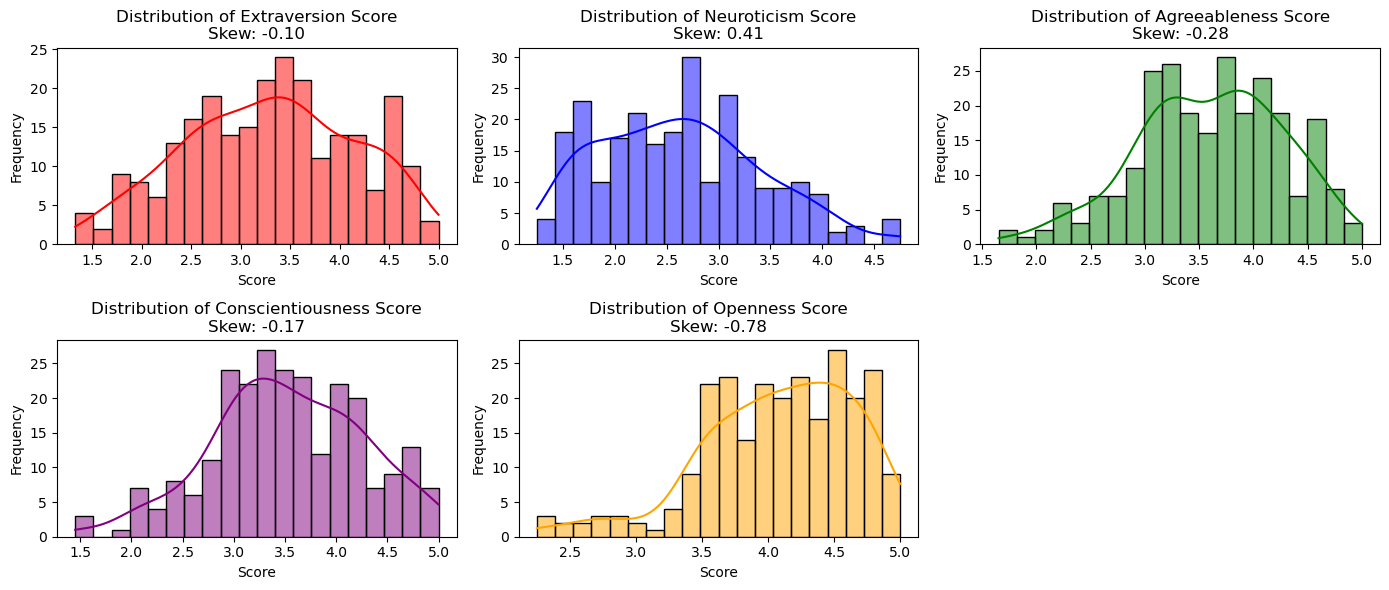

In [194]:
# Calculate skewness for each personality score
skew_ext = skew(unique_users['sEXT'])
skew_neu = skew(unique_users['sNEU'])
skew_agr = skew(unique_users['sAGR'])
skew_con = skew(unique_users['sCON'])
skew_opn = skew(unique_users['sOPN'])

# Plotting the distributions
plt.figure(figsize=(14, 6))

# for sEXT (Extraversion)
plt.subplot(2, 3, 1)  # -- > (nrows, ncols, index)
sns.histplot(unique_users['sEXT'], bins=20, kde=True, color='red')
plt.title(f'Distribution of Extraversion Score\nSkew: {skew_ext:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sNEU (Neuroticism)
plt.subplot(2, 3, 2)
sns.histplot(unique_users['sNEU'], bins=20, kde=True, color='blue')
plt.title(f'Distribution of Neuroticism Score\nSkew: {skew_neu:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sAGR (Agreeableness)
plt.subplot(2, 3, 3)
sns.histplot(unique_users['sAGR'], bins=20, kde=True, color='green')
plt.title(f'Distribution of Agreeableness Score\nSkew: {skew_agr:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sCON (Conscientiousness)
plt.subplot(2, 3, 4)
sns.histplot(unique_users['sCON'], bins=20, kde=True, color='purple')
plt.title(f'Distribution of Conscientiousness Score\nSkew: {skew_con:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# for sOPN (Openness)
plt.subplot(2, 3, 5)
sns.histplot(unique_users['sOPN'], bins=20, kde=True, color='orange')
plt.title(f'Distribution of Openness Score\nSkew: {skew_opn:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# The distribution comparing between unrepeated users are the slightly reduce in skewed (more normal distribution)

**Use the `.describe()` method on `unique_users`:**

In [202]:
df.describe()

,sEXT,sNEU,sAGR,sCON,sOPN,status_length,status_word_count
count,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000
mean,3.354730,2.609515,3.616579,3.474244,4.130329,80.646934,14.525111
std,0.857616,0.760261,0.682490,0.737240,0.585673,68.242783,12.463420
min,1.330000,1.250000,1.650000,1.450000,2.250000,2.000000,1.000000
25%,2.710000,2.000000,3.140000,3.000000,3.750000,34.000000,6.000000
50%,3.400000,2.600000,3.650000,3.400000,4.250000,60.000000,11.000000
75%,4.000000,3.050000,4.150000,4.000000,4.550000,104.000000,19.000000
max,5.000000,4.750000,5.000000,5.000000,5.000000,435.000000,89.000000


In [200]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN,status_length,status_word_count
count,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000
mean,3.292120,2.627240,3.600320,3.522920,4.07856,74.160000,13.528000
std,0.861368,0.776835,0.670758,0.740211,0.57506,66.660309,12.191956
min,1.330000,1.250000,1.650000,1.450000,2.25000,3.000000,1.000000
25%,2.662500,2.000000,3.150000,3.000000,3.75000,30.250000,5.000000
50%,3.300000,2.590000,3.660000,3.500000,4.15000,54.500000,10.000000
75%,4.000000,3.150000,4.100000,4.050000,4.50000,89.750000,17.000000
max,5.000000,4.750000,5.000000,5.000000,5.00000,415.000000,83.000000


In [206]:
diff = df.describe() - unique_users.describe()
diff

# have not much difference in statistically

,sEXT,sNEU,sAGR,sCON,sOPN,status_length,status_word_count
count,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000
mean,0.062610,-0.017725,0.016259,-0.048676,0.051769,6.486934,0.997111
std,-0.003752,-0.016573,0.011732,-0.002971,0.010614,1.582474,0.271464
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.047500,0.000000,-0.010000,0.000000,0.000000,3.750000,1.000000
50%,0.100000,0.010000,-0.010000,-0.100000,0.100000,5.500000,1.000000
75%,0.000000,-0.100000,0.050000,-0.050000,0.050000,14.250000,2.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,6.000000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

**Plots:**
- To show the shape and how data spread, is it normally distribtued / is it skewed or not
- Use it when you want to show and compared to other data sets / plots are easily to compare than data in table
- Plots also can show us the outliers

**Table**
- Use table when you want to provide exact numbers for measures like the mean, median, or standard deviation.

#### Other visualizations:

Create at least 2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

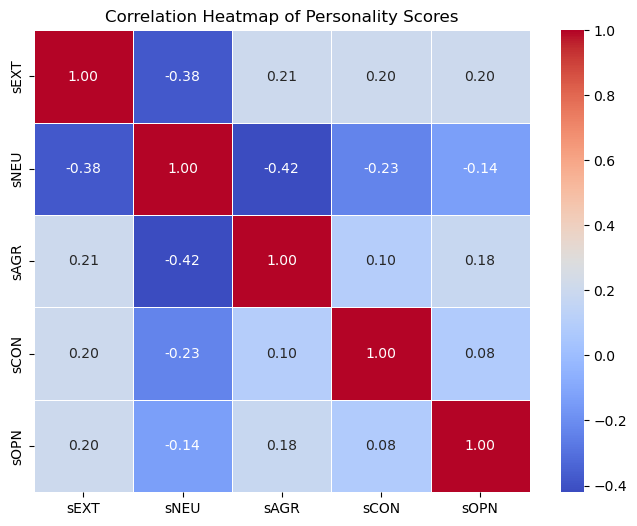

In [213]:
# Seaborn correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = unique_users[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Personality Scores')
plt.show()

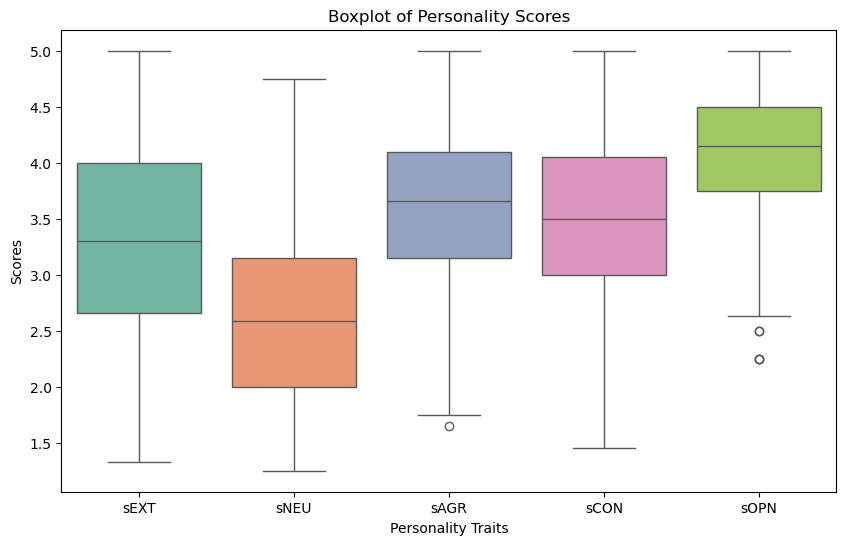

In [231]:
# boxplot of users per traits and the scoring of each
plt.figure(figsize=(10, 6))
sns.boxplot(data=unique_users[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']], palette="Set2")
plt.title('Boxplot of Personality Scores')
plt.ylabel('Scores')
plt.xlabel('Personality Traits')
plt.show()

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [293]:
# create function
def mean_c_length_count(traits):
    results = {}

    for trait in traits:
        # group by the current trait
        group = unique_users.groupby(trait)[['status_length', 'status_word_count']].mean()
        results[trait] = group

    # display results for each trait
    for trait, result in results.items():
        print(f"Mean status length and word count for {trait}:")
        print(result)
        print()
        return results

In [273]:
traits = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']  #show high and low
mean_c_length_count(traits)

Mean status length and word count for cEXT:
      status_length  status_word_count
cEXT                                  
n         75.116883          13.571429
y         72.625000          13.458333

Mean status length and word count for cNEU:
      status_length  status_word_count
cNEU                                  
n         75.079470          13.549669
y         72.757576          13.494949

Mean status length and word count for cAGR:
      status_length  status_word_count
cAGR                                  
n         77.163793          14.120690
y         71.559701          13.014925

Mean status length and word count for cCON:
      status_length  status_word_count
cCON                                  
n         78.508333          14.500000
y         70.146154          12.630769

Mean status length and word count for cOPN:
      status_length  status_word_count
cOPN                                  
n         72.283784          12.918919
y         74.948864          13.784

**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

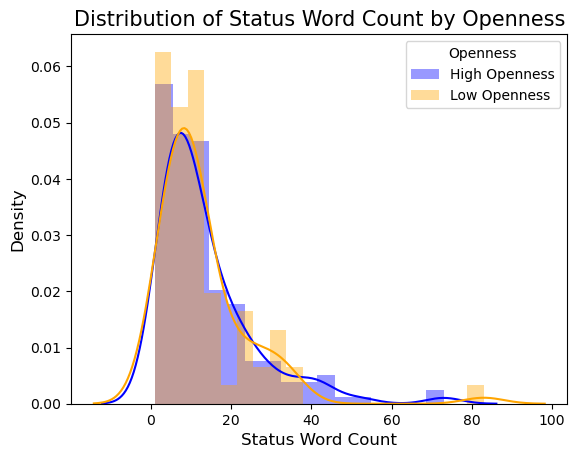

In [315]:
# choosing cOPN
sns.distplot(unique_users[unique_users['cOPN'] == 'y']['status_word_count'], kde=True, color='blue', label='High Openness')
sns.distplot(unique_users[unique_users['cOPN'] == 'n']['status_word_count'], kde=True, color='orange', label='Low Openness')

plt.title('Distribution of Status Word Count by Openness', size=15)
plt.xlabel('Status Word Count', size=12)
plt.ylabel('Density', size=12)
plt.legend(title='Openness', loc='upper right');


---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names_out()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.


$$**Summary**$$
| **Feature**           | **Sparse Matrix**                     | **Dense Matrix**                     |
|------------------------|----------------------------------------|---------------------------------------|
| **Storage**            | Only non-zero elements and their indices | All elements, including zeros        |
| **Memory Usage**       | Memory-efficient for sparse data       | Requires more memory                  |
| **Computation Speed**  | Faster for sparse-specific operations  | Faster for general operations         |
| **Suitability**        | Best for large, sparse datasets        | Best for dense or small datasets      |


### Show the 15 most common words

#### Without adjusting hyperparameters

In [378]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))

# Fit the vectorizer on 'status'
cvec.fit(unique_users['STATUS'])
X = cvec.transform(df['STATUS'])

# Convert to dense format
X_dense = X.toarray()
# Use .toarray() for modern applications, as NumPy recommends transitioning away from matrix objects.
# Avoid .todense() unless working with legacy codebases or APIs that explicitly require a matrix object.

# convert to dataframe
status_cvec_df = pd.DataFrame(X_dense, columns=cvec.get_feature_names_out())

word_counts = status_cvec_df.sum(axis=0)

# Top 15 words
most_common_words = word_counts.sort_values(ascending=False).head(15)
most_common_words

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

#### With adjusting hyperparameters

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

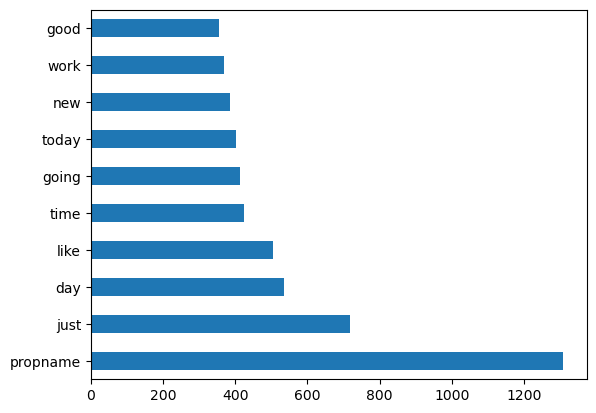

In [382]:
# plot
status_cvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [375]:
unique_users[unique_users['STATUS'].str.contains('propname', case=False, na=False)][['STATUS']].head(10)

,STATUS
3916,"says ""Sorry Orlando but *PROPNAME* failed the Heat. He was always going to fail you."""
4872,Now we are headed to *PROPNAME*'s to watch *PROPNAME* and Me again!
4982,"is trying to get in touch with the notorious V.A.L. Yo, *PROPNAME*, call be back sistah!"
5141,hanging out with *PROPNAME* :)
5522,"is glad *PROPNAME* has taken responsibility for what happened. Don't worry, *PROPNAME*, I'm not mad at you!"
6292,I may be the only *PROPNAME* in the world - I'm definitely the only one on Facebook.
6418,"(purposefully contradicting *PROPNAME*) AGHH!! The heat! *opens arms in welcoming fashion*. I mean, you all complain when it's cold and rainy, as per usual, and you complain when it's warm. CONSISTENCY, PEOPLE!"
7013,is up and down in the WSOP cash games... and he just finished reading Brave New World by *PROPNAME* & Death by Black Hole by *PROPNAME*. Both books were good.
7319,is taking a nap and dreamin of *PROPNAME*
7759,R.I.P *PROPNAME*! You and your music will alway be in my heart :(


**Provide a short explanation of what you believe `propname` to be:**

By reading the sentences above, I think 'propname' is the name od a person / or may be the account name that facebook want to hide from ( for privatcy purpose)

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [392]:
text_and_scores = pd.concat([df[['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']], status_cvec_df], axis=1)
text_and_scores

,cOPN,cCON,cEXT,cAGR,cNEU,00,00 01,000,000 feet,01,...,yogurt,yogurt covered,yoooo,yoooo just,youtube,youtube rules,zugspitze,zugspitze rothenburg,äslkar,äslkar sverige
0,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,y,n,n,y,n,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9912,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9913,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9914,y,n,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Show the 25 most common words for statuses from high-cAGR users:**

In [416]:
high_cAGR = text_and_scores[text_and_scores['cAGR'] == 'y']

word_counts_high_cAGR = high_cAGR.sum(numeric_only=True, axis=0)

# Top 15 words
most_common_words_high_cAGR = word_counts_high_cAGR.sort_values(ascending=False).head(25)
most_common_words_high_cAGR

propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
got         157
know        157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
ll          103
great        99
dtype: int64

**Show the 25 most common words for statuses from low-cAGR users:**

In [418]:
high_cAGR = text_and_scores[text_and_scores['cAGR'] == 'n']

word_counts_high_cAGR = high_cAGR.sum(numeric_only=True, axis=0)

# Top 15 words
most_common_words_high_cAGR = word_counts_high_cAGR.sort_values(ascending=False).head(25)
most_common_words_high_cAGR

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
know        119
really      119
people      112
want        109
happy       107
week         98
sleep        97
dtype: int64

### Most common bigrams:

Find the 10 most common [**bigrams**](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [430]:
# cvec with ngram=(2,2)
cvec = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform 
X = cvec.fit_transform(df['STATUS'])

# To dense from sparse
X_dense = X.toarray()

# sum the word counts 
bigram_counts = X_dense.sum(axis=0)  

# create a pandas Series with bigrams and their counts
bigram_freq = pd.Series(bigram_counts, index=cvec.get_feature_names_out())

# get top 11 and exclude propname --> top 10 
top_10_bigrams = bigram_freq.sort_values(ascending=False).head(11)

print(top_10_bigrams[1:12])  # exclude the propname

just got           55
new year           53
http www           46
merry christmas    44
looking forward    43
feel like          39
happy new          32
don know           31
birthday wishes    29
feels like         28
dtype: int64


### Most common trigrams:

Find the 10 most common [**trigrams**](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [440]:
# cvec with ngram=(2,2)
cvec = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit and transform 
X = cvec.fit_transform(df['STATUS'])

# To dense from sparse
X_dense = X.toarray()

# sum the word counts 
trigram_counts = X_dense.sum(axis=0)  

# create a pandas Series with bigrams and their counts
trigram_freq = pd.Series(trigram_counts, index=cvec.get_feature_names_out())

# get top 11 and exclude propname --> top 10 
top_10_trigrams = trigram_freq.sort_values(ascending=False).head(11)

print(top_10_trigrams[1:12])  # exclude the propname

gainesville film industry     23
www examiner com              23
http www examiner             23
24676 gainesville film        23
film industry examiner        23
happy new year                21
examiner com examiner         20
com examiner 24676            20
examiner 24676 gainesville    20
downtown comedy club          16
dtype: int64


---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

### Do users with high Openness (cOPN = 'y') post longer statuses compared to users with low Openness?

In [460]:
low_OPN.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [474]:
# high openess
high_OPN = unique_users[unique_users['cOPN'] == 'y']

# low openess
low_OPN = unique_users[unique_users['cOPN'] == 'n']

In [470]:
low_OPN['status_word_count'].describe()

count    74.000000
mean     12.918919
std      11.968860
min       1.000000
25%       5.250000
50%      10.000000
75%      14.000000
max      83.000000
Name: status_word_count, dtype: float64

In [472]:
high_OPN['status_word_count'].describe()

count    176.000000
mean      13.784091
std       12.309299
min        1.000000
25%        5.000000
50%       10.000000
75%       18.000000
max       73.000000
Name: status_word_count, dtype: float64

It can be noticed that people who are high openness are more likely to post more frequently than who are low openness. Surprisingly, the numbe rof word count of high openess people(73) are more lesser than low openness people(83).

### Is punctuation use related to personality?

In [479]:
unique_users.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

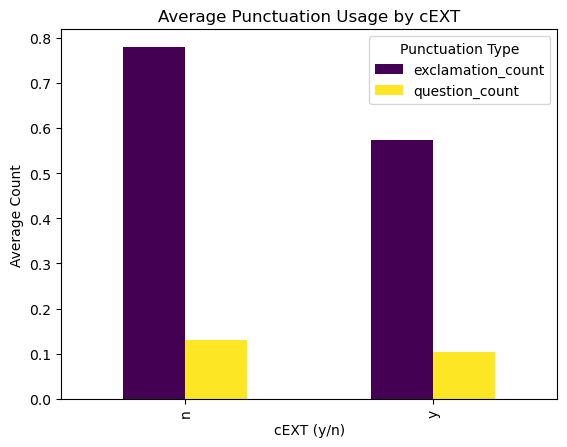

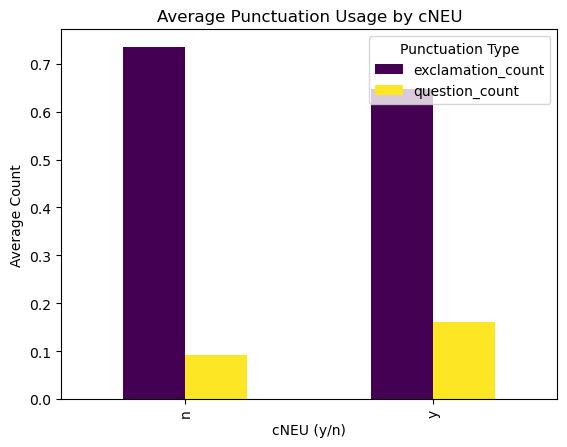

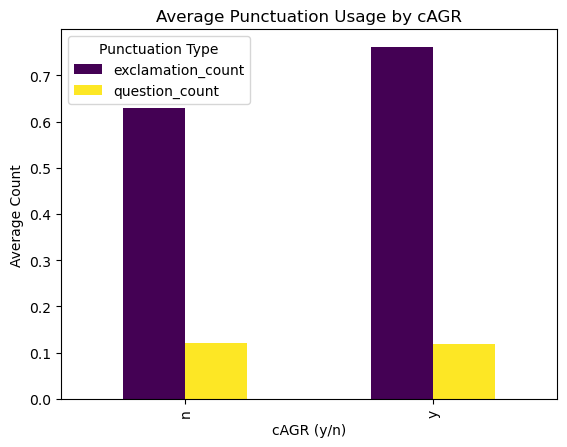

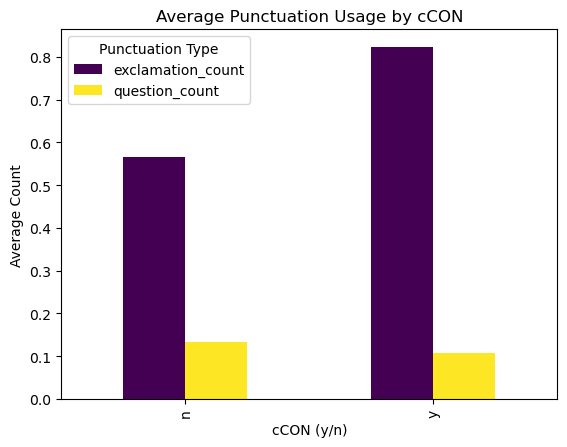

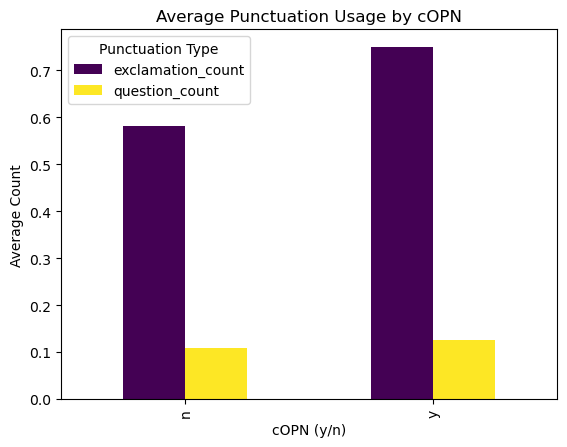

In [511]:
# counting the ! and ? in STATUS
unique_users.loc[:, 'exclamation_count'] = unique_users['STATUS'].str.count(r'!')
unique_users.loc[:, 'question_count'] = unique_users['STATUS'].str.count(r'\?')

# group into personality 
punctuation_by_cEXT = unique_users.groupby('cEXT')[['exclamation_count', 'question_count']].mean()
punctuation_by_cNEU = unique_users.groupby('cNEU')[['exclamation_count', 'question_count']].mean()
punctuation_by_cAGR = unique_users.groupby('cAGR')[['exclamation_count', 'question_count']].mean()
punctuation_by_cCON = unique_users.groupby('cCON')[['exclamation_count', 'question_count']].mean()
punctuation_by_cOPN = unique_users.groupby('cOPN')[['exclamation_count', 'question_count']].mean()

# looping through each personality 
punctuation_by = {
    'cEXT': punctuation_by_cEXT,
    'cNEU': punctuation_by_cNEU,
    'cAGR': punctuation_by_cAGR,
    'cCON': punctuation_by_cCON,
    'cOPN': punctuation_by_cOPN,
}
for personal, data in punctuation_by.items():
    data.plot(kind='bar', colormap='viridis')
    plt.title(f'Average Punctuation Usage by {personal}')
    plt.xlabel(f'{personal} (y/n)')
    plt.ylabel('Average Count')
    plt.legend(title='Punctuation Type')
    plt.show()

High of Openness, Conscientiousness, and Agreeable are the perosnality types that have using exclamation marks that are higher than the question marks than compared to the other two personalities. However, I think that using pucntuation is have affect on the personality type. For example, extroverts are more questionable about things

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [**exploratory vs. explanatory analysis**](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

### Is average word count per status related to any personality category or personality metric?

In [539]:
# Calculate average word count for each personality category
personality_categories = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
avg_word_count = {}

for category in personality_categories:
    avg_word_count[category] = unique_users.groupby(category)['status_word_count'].median()

In [540]:
avg_word_count_df

,Personality,Low,High
0,cEXT,10.0,9.5
1,cNEU,10.0,10.0
2,cAGR,10.0,10.0
3,cCON,10.5,9.0
4,cOPN,10.0,10.0


In [549]:
new_df  = avg_word_count_df.melt(id_vars='Personality', var_name='Trait Level', value_name='Avg Word Count')  
# melt = make low and high column into one

# id_vars: This keeps the Personality column as the identifier (the key for grouping).
# var_name: The new column name that will represent the original columns (Low, High).
# value_name: The new column that will hold the average word counts for each trait level.
new_df

,Personality,Trait Level,Avg Word Count
0,cEXT,Low,10.0
1,cNEU,Low,10.0
2,cAGR,Low,10.0
3,cCON,Low,10.5
4,cOPN,Low,10.0
5,cEXT,High,9.5
6,cNEU,High,10.0
7,cAGR,High,10.0
8,cCON,High,9.0
9,cOPN,High,10.0


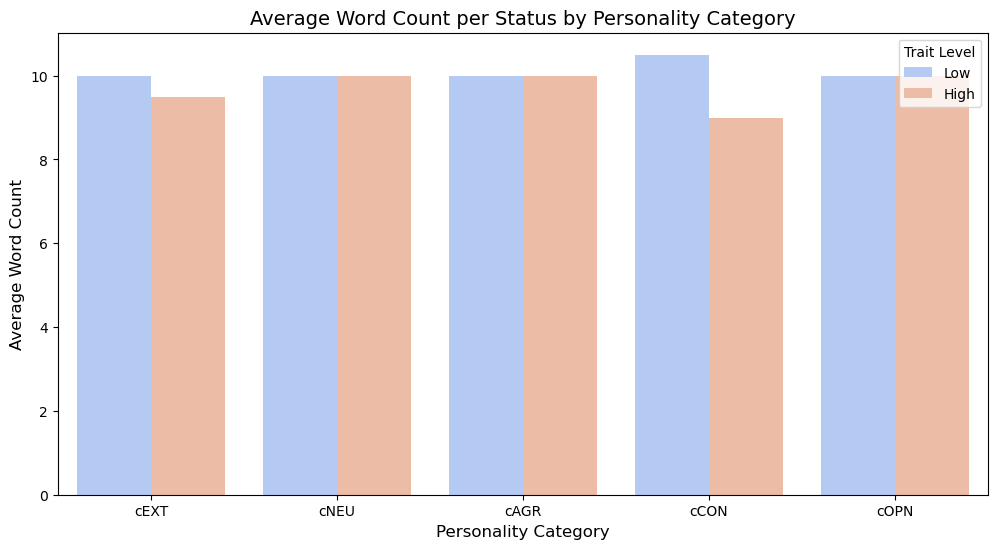

In [553]:
# creat dataframe
avg_word_count_df = pd.DataFrame(avg_word_count).T
avg_word_count_df.columns = ['Low', 'High']
avg_word_count_df.index.name = 'Personality'
avg_word_count_df = avg_word_count_df.reset_index()

# creat graph
plt.figure(figsize=(12, 6))
sns.barplot(data=new_df, x='Personality', y='Avg Word Count', hue='Trait Level', palette='coolwarm')
plt.title('Average Word Count per Status by Personality Category', fontsize=14)
plt.xlabel('Personality Category', fontsize=12)
plt.ylabel('Average Word Count', fontsize=12)
plt.legend(title='Trait Level')
plt.show()

**Observations by Personality Category:**
For neu, agr , and opn , the average word count are the same as around 10 words for both Low and High. However, on the con, and ext, High level of traits are lesser than the Low traits of con and ext. Meaning that written communication (statuses) is not much influenced by personality trait levels. However, small difference are there.